# C23-PR588 AUD/IDR DNN MODEL 

Import necessary libraries

In [29]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [30]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
aud_idr_df = currencies_df[['date', 'AUD']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(aud_idr_df.head())
display(aud_idr_df.tail())

,date,AUD
0,2013-05-01,9991.932116
1,2013-05-02,9976.629029
2,2013-05-03,10024.671009
3,2013-05-04,10037.051582
4,2013-05-05,9999.337595


,date,AUD
3648,2023-04-27,9743.131115
3649,2023-04-28,9706.330826
3650,2023-04-29,9696.280669
3651,2023-04-30,9699.881962
3652,2023-05-01,9719.609412


Each data point is composed of the date and the recorded exchange rate from AUD to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

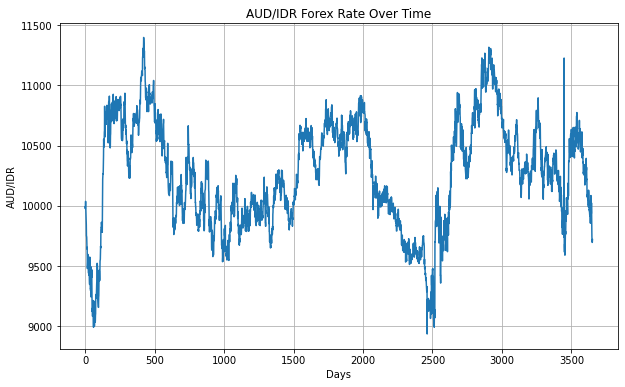

In [31]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = aud_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'AUD')
    TIME = times
    SERIES = values
    SPLIT_TIME = int(math.floor(len(values)*0.8))
    SPLIT_TIME_STEP = int(math.floor(len(values)*0.5))
    SPLIT_TIME_STOP = int(math.floor(len(values)*0.7))
    SPLIT_TIME_STEP_2 = int(math.floor(len(values)*0.7))
    SPLIT_TIME_STOP_2 = int(math.floor(len(values)*0.9))
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="AUD/IDR Forex Rate Over Time", xlabel="Days", ylabel="AUD/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [32]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME_STEP, G.SPLIT_TIME_STOP)

In [33]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Defining the model architecture

In [34]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(30, input_shape=[G.WINDOW_SIZE], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)

    ])

    return model

In [35]:
# Create and test model
model = create_model()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Adjusting the learning rate

In [37]:
def adjust_learning_rate(dataset, model_to_train):

    model = model_to_train

    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer)
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [38]:
# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

Epoch 1/100
57/57 [==============================] - 1s 3ms/step - loss: 3292.5332 - lr: 1.0000e-08
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 210.4556 - lr: 1.1220e-08
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 176.7108 - lr: 1.2589e-08
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 174.9014 - lr: 1.4125e-08
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 173.9521 - lr: 1.5849e-08
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 184.3194 - lr: 1.7783e-08
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 172.5755 - lr: 1.9953e-08
Epoch 8/100
57/57 [==============================] - 0s 2ms/step - loss: 173.9402 - lr: 2.2387e-08
Epoch 9/100
57/57 [==============================] - 0s 2ms/step - loss: 172.8346 - lr: 2.5119e-08
Epoch 10/100
57/57 [==============================] - 0s 2ms/step - loss: 171.6062 - lr: 2.8184e-08
Epoch 11

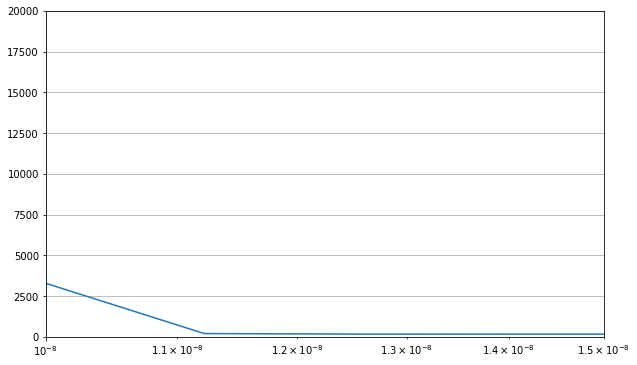

In [39]:
plt.figure(figsize=(10, 6))

# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

In [40]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Compiling the model

In [41]:
def compile_model(dataset, model_to_train):

    model = model_to_train

    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
        
    # Train the model
    history = model.fit(dataset, epochs=100)

    return history

In [42]:
history = compile_model(train_set, model)

Epoch 1/100
57/57 [==============================] - 1s 3ms/step - loss: 3302.5356 - mae: 3303.0356
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 213.2796 - mae: 213.7789
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 178.1026 - mae: 178.6023
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 175.3844 - mae: 175.8841
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 181.6132 - mae: 182.1124
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 177.4804 - mae: 177.9801
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 175.0143 - mae: 175.5136
Epoch 8/100
57/57 [==============================] - 0s 2ms/step - loss: 173.2883 - mae: 173.7877
Epoch 9/100
57/57 [==============================] - 0s 2ms/step - loss: 171.9476 - mae: 172.4470
Epoch 10/100
57/57 [==============================] - 0s 2ms/step - loss: 171.7145 - mae: 172.2143
Epoch 11/100
57/5

## Visualize MAE and loss

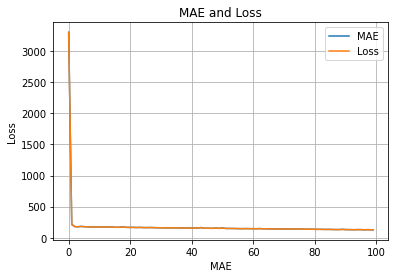

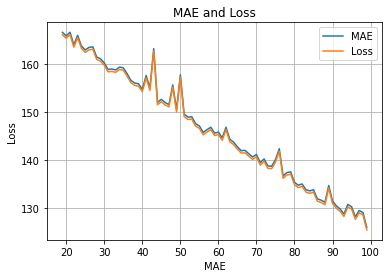

In [43]:
visualize_mae_loss(history)

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 0s 4ms/step


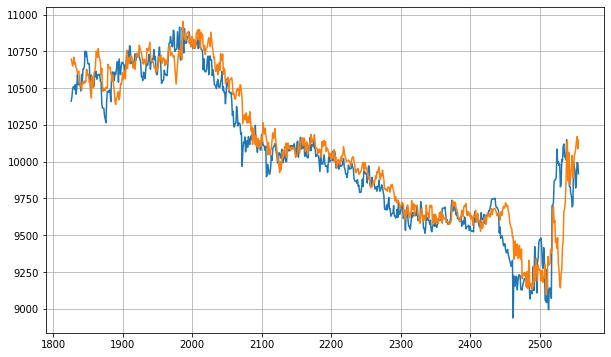

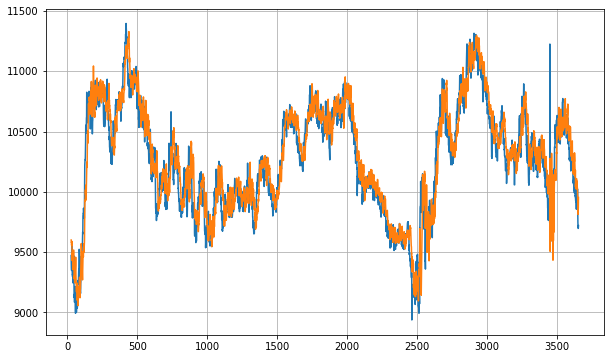

In [44]:
dnn_forecast_valid = evaluate_forecast(model, G.TIME, G.SERIES, time_valid, series_valid,
                      G.SPLIT_TIME_STEP, G.SPLIT_TIME_STOP-1, G.WINDOW_SIZE, G.BATCH_SIZE)

In [45]:
compute_metrics(series_valid, dnn_forecast_valid)

{'mae': 549.5936, 'mse': 461278.44, 'rmse': 660.6368, 'mape': 5.495246}

In [46]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

2 last Actual Price = [[9988.646813]
 [9918.393631]], Predicted Price = [10087.592 10147.01 ]


## Expanding Window Approach
Done by modelling train/val with 50:20, 70:20, then 80:20 ratio

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

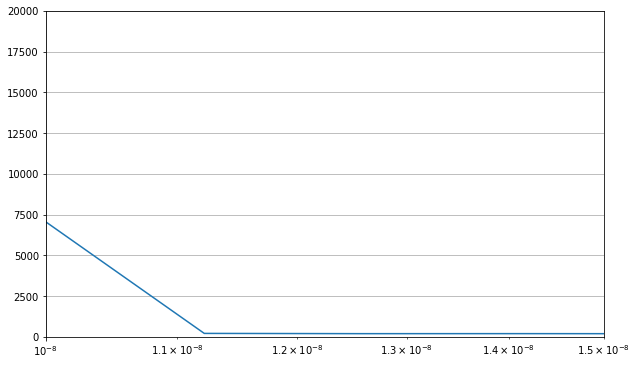

In [47]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME_STEP_2, G.SPLIT_TIME_STOP_2)

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

# Create and test model
model = create_model()

# Print the model summary
model.summary()

# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

plt.figure(figsize=(10, 6))

# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

Epoch 1/100
79/79 [==============================] - 1s 3ms/step - loss: 7062.1235 - mae: 7062.6230
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 222.8929 - mae: 223.3919
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 204.5709 - mae: 205.0701
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 201.6591 - mae: 202.1586
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 201.8167 - mae: 202.3161
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 151.4933 - mae: 151.9924
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 124.5728 - mae: 125.0716
Epoch 8/100
79/79 [==============================] - 0s 3ms/step - loss: 125.4944 - mae: 125.9935
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 124.7270 - mae: 125.2265
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 124.8908 - mae: 125.3901
Epoch 11/100
79/7

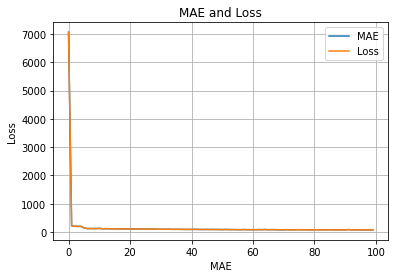

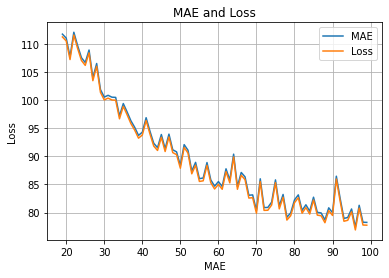

In [48]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

history = compile_model(train_set, model)

visualize_mae_loss(history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 0s 4ms/step


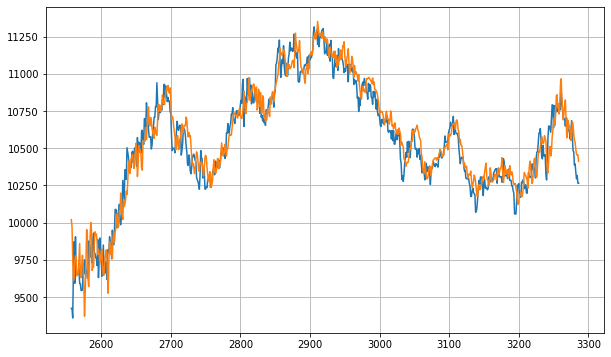

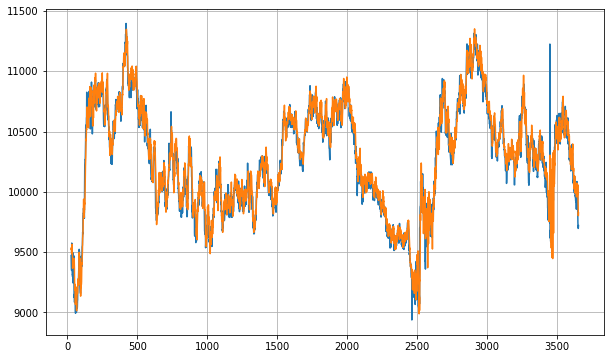

{'mae': 428.21436, 'mse': 292586.44, 'rmse': 516.05524, 'mape': 4.086985}

2 last Actual Price = [[10264.863138]
 [10264.685026]], Predicted Price = [10455.635 10411.393]


In [49]:
dnn_forecast_valid = evaluate_forecast(model, G.TIME, G.SERIES, time_valid, series_valid,
                      G.SPLIT_TIME_STEP_2, G.SPLIT_TIME_STOP_2-1, G.WINDOW_SIZE, G.BATCH_SIZE)

display(compute_metrics(series_valid, dnn_forecast_valid))

print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

Now for the last time, 80:20 ratio

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

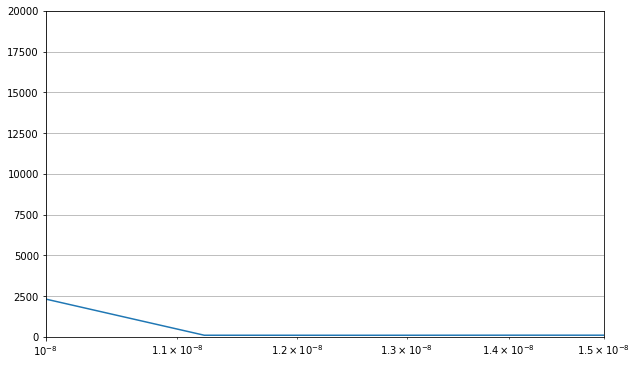

In [50]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME, None)

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

# Create and test model
model = create_model()

# Print the model summary
model.summary()

# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

plt.figure(figsize=(10, 6))

# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 2312.7871 - mae: 2313.2869
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 116.0822 - mae: 116.5815
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 103.6771 - mae: 104.1761
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 105.7621 - mae: 106.2610
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 107.8248 - mae: 108.3237
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 105.2763 - mae: 105.7751
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 107.0387 - mae: 107.5379
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 103.4787 - mae: 103.9778
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 107.5230 - mae: 108.0224
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 104.7460 - mae: 105.2451
Epoch 11/100
91/9

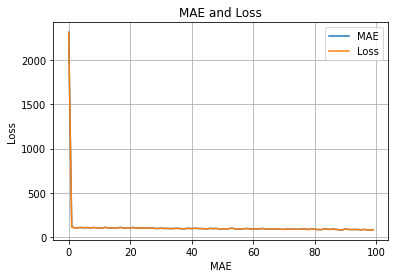

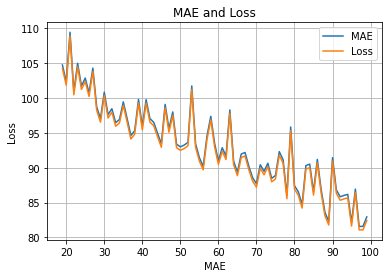

In [51]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

history = compile_model(train_set, model)

visualize_mae_loss(history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 0s 3ms/step


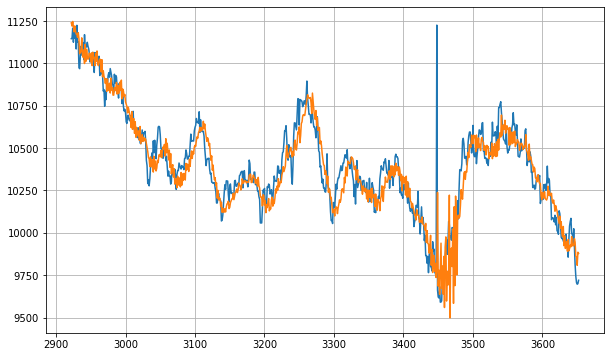

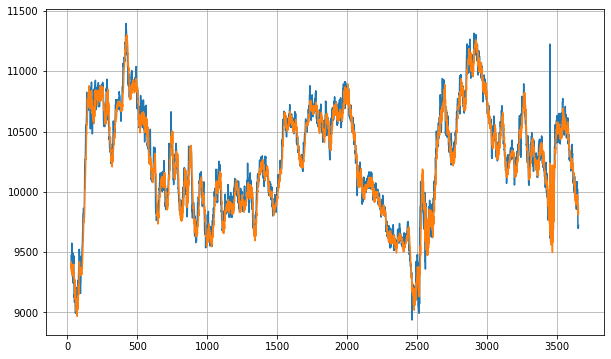

{'mae': 335.22192, 'mse': 183897.3, 'rmse': 406.78275, 'mape': 3.2170126}

2 last Actual Price = [[9699.881962]
 [9719.609412]], Predicted Price = [9885.291 9878.163]


In [52]:
dnn_forecast_valid = evaluate_forecast(model, G.TIME, G.SERIES, time_valid, series_valid,
                      G.SPLIT_TIME, -1, G.WINDOW_SIZE, G.BATCH_SIZE)

display(compute_metrics(series_valid, dnn_forecast_valid))

print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

## Save Model

In [53]:
path = get_model_dir(PATH)
model.save(path)

INFO:tensorflow:Assets written to: ./saved_model/3/assets


INFO:tensorflow:Assets written to: ./saved_model/3/assets


## Future Predictions

In [54]:
into_future = 100

future_forecast = make_future_forecast(values=G.SERIES,
                                       model=model,
                                       into_future=into_future,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [[ 9991.164594]
 [10129.656911]
 [10112.958701]
 [10052.054014]
 [ 9973.110625]
 [ 9965.620727]
 [ 9968.598951]
 [ 9950.687169]
 [ 9947.506228]
 [ 9927.536872]
 [ 9940.046811]
 [ 9991.557014]
 [ 9913.167687]
 [ 9917.60924 ]
 [ 9856.107891]
 [ 9961.256773]
 [10040.224458]
 [10066.447283]
 [10085.21644 ]
 [ 9995.16504 ]
 [ 9995.165155]
 [ 9935.947873]
 [10023.99686 ]
 [ 9915.824429]
 [ 9812.169065]
 [ 9743.131115]
 [ 9706.330826]
 [ 9696.280669]
 [ 9699.881962]
 [ 9719.609412]] -> Prediction: 9817.91796875

1/1 [==============================] - 0s 49ms/step
Predicting on:
 [10129.656911   10112.958701   10052.054014    9973.110625
  9965.620727    9968.598951    9950.687169    9947.506228
  9927.536872    9940.046811    9991.557014    9913.167687
  9917.60924     9856.107891    9961.256773   10040.224458
 10066.447283   10085.21644     9995.16504     9995.165155
  9935.947873   10023.99686     9915.824429    9812.169065

In [55]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast = np.insert(future_forecast, 0, G.SERIES[-1])

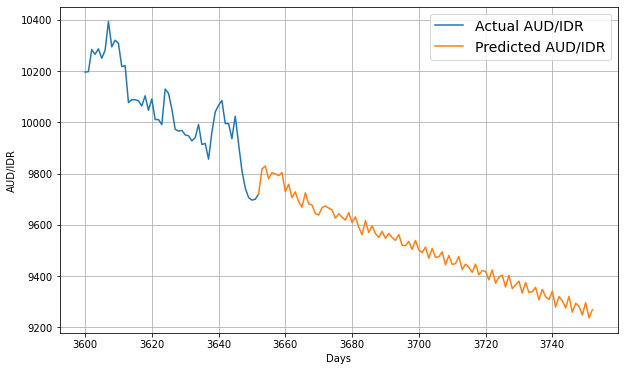

In [56]:
plt.figure(figsize=(10, 6))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual AUD/IDR", xlabel="Days", ylabel="AUD/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Predicted AUD/IDR", xlabel="Days", ylabel="AUD/IDR")

Model is unstable and mostly overfitted, the MAE is over 100 which make this model a bad model